<a href="https://colab.research.google.com/github/s1kcode/Permeability-from-3D/blob/master/MNIST_InfoVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, LeakyReLU, ReLU, Dense, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import time

from IPython import display

In [ ]:
#parameters
epochs = 12
batch_size = 128
depth = 64
kernel = 3
latent_size = 2

#names
model_name = "InfoVAE-2D"

In [ ]:
train_ds, info = tfds.load('mnist', split='train', with_info=True, shuffle_files=True, download=True)
total_images = info.splits['train'].num_examples
total_batches = total_images//batch_size
total_steps = total_batches*epochs
xSize, ySize, rgbSize = info.features['image'].shape
num_classes = info.features['label'].num_classes

Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to ~/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
def normalize(item):
    '''
    Normalize the images
    '''
    image = tf.cast(item['image'], tf.float32) / 255.0
    label = item['label'] #use to_categorical for CategoricalCrossEntropy
    return image, label

train_ds = train_ds.shuffle(total_images)
train_ds = train_ds.map(normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_ds = train_ds.batch(batch_size)
train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
#generator network
def decoder_network(input_shape, activation, name='D'):
    '''
    Decodes latent space into images
    '''
    input=Input(input_shape, name=name+'input')
    dense=Dense(128, activation=ReLU(), kernel_initializer=tf.keras.initializers.GlorotNormal())(input)
    dense=Dense(1024, activation=ReLU(), kernel_initializer=tf.keras.initializers.GlorotNormal())(dense)
    dense=Dense(7*7*depth*5, activation=ReLU(), kernel_initializer=tf.keras.initializers.GlorotNormal())(dense)
    dense=Reshape((7, 7, depth*5))(dense)
    net=Conv2DTranspose(depth*2, kernel_size=kernel, padding='same', strides=2, activation=ReLU())(dense) #upsample
    net=Conv2DTranspose(depth, kernel_size=kernel, padding='same', strides=2, activation=ReLU())(net) #upsample
    network=Conv2D(1, kernel_size=[1,1], strides=1, activation=activation)(net) #RF 7 with stride
    return Model(inputs=input, outputs=network, name=name)

#discriminator network
def encoder_network(input_shape, z_dim, name='E'):
    '''
    Encodes images into latent space
    '''
    input=Input(input_shape, name=name+'input')
    net=Conv2D(depth, kernel_size=kernel, padding='same', strides=2, activation=LeakyReLU(alpha=0.1))(input) #downsample
    net=Conv2D(depth*2, kernel_size=kernel, padding='same', strides=2, activation=LeakyReLU(alpha=0.1))(net) #downsample
    dense=Flatten()(net)
    dense=Dense(1024, activation=LeakyReLU(alpha=0.1), kernel_initializer=tf.keras.initializers.GlorotNormal())(dense)
    dense=Dense(128, activation=LeakyReLU(alpha=0.1), kernel_initializer=tf.keras.initializers.GlorotNormal())(dense)
    latent=Dense(z_dim, kernel_initializer=tf.keras.initializers.GlorotNormal())(dense)
    return Model(inputs=input, outputs=latent, name=name)

mse = tf.keras.losses.MeanSquaredError()

In [ ]:
z_size = (latent_size, )
input_shape = (xSize, ySize, 1)

#build encoder
encoder = encoder_network(input_shape, latent_size)
encoder.summary(line_length=133)

def encoder_loss(latent):
    '''
    Compute Maximum-Mean Discrepancy (MMD) loss for the InfoVAE: https://arxiv.org/abs/1706.02262
    '''
    def compute_kernel(x, y):
        x_size = K.shape(x)[0]
        y_size = K.shape(y)[0]
        dim = K.shape(x)[1]
        tiled_x = K.tile(K.reshape(x, [x_size, 1, dim]), [1, y_size, 1])
        tiled_y = K.tile(K.reshape(y, [1, y_size, dim]), [x_size, 1, 1])
        return K.exp(-K.mean(K.square(tiled_x - tiled_y), axis=2) / K.cast(dim, 'float32'))

    def compute_mmd(x, y):
        x_kernel = compute_kernel(x, x)
        y_kernel = compute_kernel(y, y)
        xy_kernel = compute_kernel(x, y)
        return K.mean(x_kernel) + K.mean(y_kernel) - 2 * K.mean(xy_kernel)

    'So, we first get the mmd loss'
    'First, sample from random noise'
    batch_size = K.shape(latent)[0]
    latent_dim = K.int_shape(latent)[1]
    true_samples = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.)
    'calculate mmd loss'
    loss_mmd = compute_mmd(true_samples, latent)

    'Add them together, then you can get the final loss'
    return loss_mmd

#build decoder
decoder = decoder_network(z_size, ReLU())
decoder.summary(line_length=133)

def decoder_loss(y_true, y_pred):
    '''
    Returns reconstruction loss as L2
    '''
    return mse(y_true, y_pred)

#build VAE
input = Input(input_shape, name=model_name+'_input')
z = encoder(input)
recon = decoder(z)
vae = Model(inputs=input, outputs=recon, name=model_name)
vae.summary(line_length=133)

encoder_opt = tf.keras.optimizers.Adam(1e-4)
decoder_opt = tf.keras.optimizers.Adam(1e-4)
vae_opt = tf.keras.optimizers.Adam(1e-4)

Model: "E"
_____________________________________________________________________________________________________________________________________
 Layer (type)                                              Output Shape                                          Param #             
 Einput (InputLayer)                                       [(None, 28, 28, 1)]                                   0                   
                                                                                                                                     
 conv2d (Conv2D)                                           (None, 14, 14, 64)                                    640                 
                                                                                                                                     
 conv2d_1 (Conv2D)                                         (None, 7, 7, 128)                                     73856               
                                                   

In [ ]:
@tf.function #compiles function, much faster
def train_step_z(images):
    '''
    The training step with the gradient tape. The switch allows for for different training schedules.
    '''
    with tf.GradientTape() as enc_tape:
        latent_codes = encoder(images, training=True)
        mmd_loss = encoder_loss(latent_codes)

    gradients_of_encoder = enc_tape.gradient(mmd_loss, encoder.trainable_variables)
    encoder_opt.apply_gradients(zip(gradients_of_encoder, encoder.trainable_variables))

    return mmd_loss

@tf.function #compiles function, much faster
def train_step_recon(images):
    '''
    The training step with the gradient tape (persistent). The switch allows for for different training schedules.
    switch = 0 (compute all gradients and losses, default)
    switch = 1 (compute first gradient and loss)
    switch = 2 (compute second gradient and loss)
    etc.
    '''
    with tf.GradientTape() as dec_tape:
        latent_codes = encoder(images, training=True)
        recons = decoder(latent_codes, training=True)
        recon_loss = decoder_loss(images, recons)

    gradients_of_decoder = dec_tape.gradient(recon_loss, decoder.trainable_variables)
    decoder_opt.apply_gradients(zip(gradients_of_decoder, decoder.trainable_variables))

    return recon_loss

@tf.function #compiles function, much faster
def train_step_vae(images):
    '''
    The training step with the gradient tape (persistent). The switch allows for for different training schedules.
    '''
    with tf.GradientTape() as vae_tape:
        latent_codes = encoder(images, training=True)
        recons = decoder(latent_codes, training=True)
        mmd_loss = encoder_loss(latent_codes)
        recon_loss = decoder_loss(images, recons)
        loss = mmd_loss + recon_loss

    gradients_of_vae = vae_tape.gradient(loss, vae.trainable_variables)
    vae_opt.apply_gradients(zip(gradients_of_vae, vae.trainable_variables))

    return loss

In [ ]:
# to visualize progress of same set in the animated GIF
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, latent_size, 1])

def train(dataset, epochs):
    losses = []
    for epoch in range(1, epochs+1):
        start = time.time()

        loss = -1
        batch_losses = 0
        switch = 1 #epoch%3
        msg = ""
        count = 0
        for image_batch, labels_batch in dataset:
            #loss = train_step(image_batch)
            if switch == 0: #optimize z
                loss = train_step_z(image_batch)
                msg = "optimize z"
            elif switch == 2: #optimize recon
                loss = train_step_recon(image_batch)
                msg = "optimize recon"
            else: #optimize vae
                loss = train_step_vae(image_batch)
                msg = "optimize vae"
            batch_losses += loss
            count += 1

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(decoder,
                                    epoch,
                                    seed)

        #compute mean losses and accuracies
        loss = batch_losses/count

        print('Time for epoch {} (loss {}, {}) is {} sec'.format(epoch, loss, msg, time.time()-start))
        losses.append(loss)

    return losses

def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(8,8))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    #plt.savefig(testing_path+'image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

def save_images(epoch, test_input):
    # Save images and image plot
    fig = plt.figure(figsize=(8,8))

    for i in range(test_input.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(test_input[i, :, :, 0], cmap='gray')
        plt.axis('off')

    #plt.savefig(testing_path+'image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

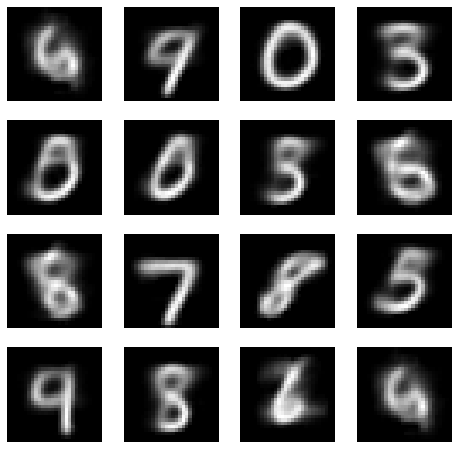

Time for epoch 12 (loss 0.04755014926195145, optimize vae) is 11.76107907295227 sec


In [ ]:
convergence = train(train_ds, epochs)

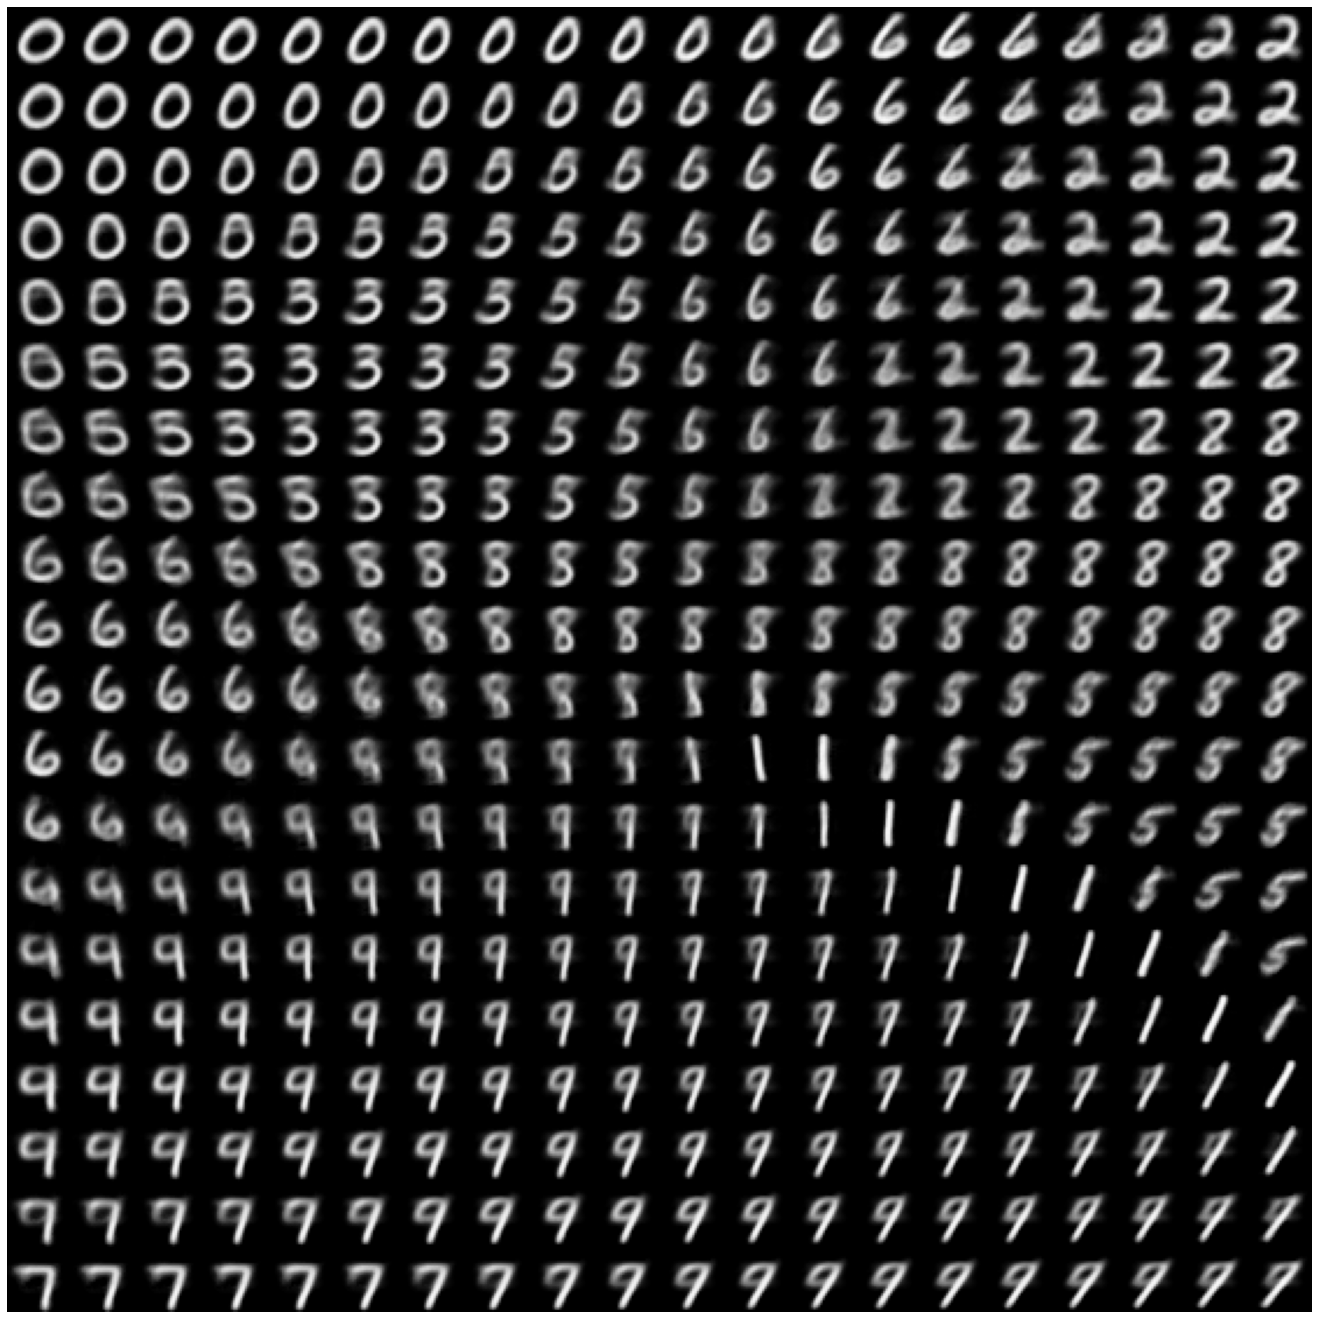

In [ ]:
def plot_latent_images(model, n, size=28):
    """Plots n x n digit images decoded from the latent space."""

    norm = tfp.distributions.Normal(0, 1)
    grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
    grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
    image_width = size*n
    image_height = image_width
    image = np.zeros((image_height, image_width))

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z = np.array([[xi, yi]])
            x_decoded = model(z, training=False)
            digit = tf.reshape(x_decoded[0], (size, size))
            image[i * size: (i + 1) * size,
                j * size: (j + 1) * size] = digit.numpy()

    plt.figure(figsize=(24, 24))
    plt.imshow(image, cmap='Greys_r')
    plt.axis('Off')
    plt.show()

plot_latent_images(decoder, 20, xSize)